# GradCAM on JAFFE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive')

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
from PIL import Image
from collections import defaultdict
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import cv2
from os import listdir
from random import shuffle
from math import floor
import shutil
import os

%matplotlib inline

# Preprocessing Data

In [ ]:
def get_train_val_test(data_list):
    index1 = floor(len(data_list)*0.8)
    index2 = floor(len(data_list)*0.9)
    training_data = data_list[:index1]
    validation_data = data_list[index1:index2]
    testing_data = data_list[index2:]
    return training_data, validation_data, testing_data


def test_val_train_split(root_dir,train_dir,val_dir, test_dir):
    path_images = listdir(root_dir)

    an = []
    fe = []
    di = []
    ha = []
    ne = []
    sa = []
    su = []

    for image in path_images:
        if(image[3:5]=='AN'):
            an.append(image)
        elif(image[3:5]=='FE'):
            fe.append(image)
        elif(image[3:5]=='DI'):
            di.append(image)
        elif(image[3:5]=='HA'):
            ha.append(image)
        elif(image[3:5]=='NE'):
            ne.append(image)
        elif(image[3:5]=='SA'):
            sa.append(image)
        elif(image[3:5]=='SU'):
            su.append(image)
        else:
            print(image)


    image_dict = {"AN":an,"FE":fe,"DI":di,"HA":ha,"NE":ne,"SA":sa,"SU":su}


    for keys in image_dict:
        shuffle(image_dict[keys])
        training_data, validation_data, testing_data = get_train_val_test(image_dict[keys])

        for i_image in training_data:
            dst_an = train_dir+"/"+keys
            src_an = root_dir+"/"+i_image
            img = cv2.imread(src_an)
            shutil.copy(src_an,dst_an)
            #cv2.imwrite(dst_an+'/'+i_image[:-4]+'jpg', img)

        for i_image in validation_data:
            dst_an = val_dir+"/"+keys
            src_an = root_dir+"/"+i_image
            img = cv2.imread(src_an)
            shutil.copy(src_an,dst_an)
            #cv2.imwrite(dst_an+'/'+i_image[:-4]+'jpg', img)

        for i_image in testing_data:
            dst_an = test_dir+"/"+keys
            src_an = root_dir+"/"+i_image
            img = cv2.imread(src_an)
            shutil.copy(src_an,dst_an)
            #cv2.imwrite(dst_an+'/'+i_image[:-4]+'jpg', img)


In [ ]:
# Create directories for training, validation, and test sets
splits = ['train', 'validation', 'test']
emotions = ["FE", "AN", "DI", "HA", "NE", "SA", "SU"]  # Emotion labels

for split in splits:
    for emotion in emotions:
        os.makedirs(os.path.join("/content/drive/My Drive/data", split, emotion), exist_ok=True)

In [ ]:
source_dir =  "/content/drive/My Drive/jaffedbase"
train_dir = "/content/drive/My Drive/data/train"
val_dir = "/content/drive/My Drive/data/validation"
test_dir = "/content/drive/My Drive/data/test"

test_val_train_split(source_dir, train_dir, val_dir, test_dir)

# Define Transformation and Initialize Datasets

In [ ]:
# Train Transformation with Data augmentation of horizontal mirroring, ±10 degree rotations, ±10% image zooms, and ±10% horizontal/vertical shifting,
# Pixel values normalized to [-1, 1]
train_transform_with_augmentation = transforms.Compose([
    transforms.Resize((224, 224)), # Resize for the model
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1), # ±10% horizontal and vertical shifting
        scale=(0.9, 1.1) # ±10% zoom (scale between 90% and 110%)
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])


# Get dataset from Image Folder

In [ ]:
train_dataset_with_augmentation = datasets.ImageFolder(train_dir, transform=train_transform_with_augmentation)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


# Create Dataloader

In [ ]:
BATCH_SIZE = 16

train_augmented_dataloader = DataLoader(train_dataset_with_augmentation, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Train using non-pretrained ResNet18 model

In [ ]:
#model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
EPOCHS = 80
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for images, labels in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [ ]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_augmented_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 2.1973,          Train acc: 0.1648,          Val loss: 2.4153,          Val acc: 0.1250          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 2.2649,          Train acc: 0.0795,          Val loss: 3.5667,          Val acc: 0.3000          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 2.0257,          Train acc: 0.1761,          Val loss: 2.0873,          Val acc: 0.0625          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 2.0132,          Train acc: 0.1364,          Val loss: 1.8646,          Val acc: 0.1875          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.9579,          Train acc: 0.1705,          Val loss: 2.0305,          Val acc: 0.0938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.9191,          Train acc: 0.2045,          Val loss: 1.7690,          Val acc: 0.2937          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.8134,          Train acc: 0.3011,          Val loss: 5.2968,          Val acc: 0.0938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.7592,          Train acc: 0.3068,          Val loss: 4.1631,          Val acc: 0.0938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.8427,          Train acc: 0.3125,          Val loss: 35.2702,          Val acc: 0.0938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.5702,          Train acc: 0.4261,          Val loss: 3.7602,          Val acc: 0.0938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.5413,          Train acc: 0.4205,          Val loss: 7.6999,          Val acc: 0.1562          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 1.4768,          Train acc: 0.4432,          Val loss: 5.4133,          Val acc: 0.1937          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 1.2228,          Train acc: 0.4886,          Val loss: 4.7897,          Val acc: 0.3625          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 1.2666,          Train acc: 0.4943,          Val loss: 7.3553,          Val acc: 0.1937          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 1.1474,          Train acc: 0.4943,          Val loss: 7.3971,          Val acc: 0.2188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16,          Train loss: 1.1064,          Train acc: 0.5568,          Val loss: 1.6738,          Val acc: 0.4500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17,          Train loss: 1.0851,          Train acc: 0.5682,          Val loss: 1.7993,          Val acc: 0.5500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18,          Train loss: 1.0375,          Train acc: 0.5682,          Val loss: 1.6232,          Val acc: 0.4938          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19,          Train loss: 1.0410,          Train acc: 0.5852,          Val loss: 1.6014,          Val acc: 0.4500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20,          Train loss: 0.8784,          Train acc: 0.6477,          Val loss: 1.0653,          Val acc: 0.6562          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21,          Train loss: 0.7829,          Train acc: 0.6761,          Val loss: 6.0604,          Val acc: 0.3562          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22,          Train loss: 0.9567,          Train acc: 0.6477,          Val loss: 1.5295,          Val acc: 0.5188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23,          Train loss: 0.7484,          Train acc: 0.6989,          Val loss: 0.9181,          Val acc: 0.7188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24,          Train loss: 0.9958,          Train acc: 0.6193,          Val loss: 4.9927,          Val acc: 0.3187          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25,          Train loss: 0.9967,          Train acc: 0.6023,          Val loss: 4.9432,          Val acc: 0.1937          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26,          Train loss: 0.8414,          Train acc: 0.6989,          Val loss: 1.1653,          Val acc: 0.5188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27,          Train loss: 0.7089,          Train acc: 0.6932,          Val loss: 2.8281,          Val acc: 0.3875          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28,          Train loss: 0.6527,          Train acc: 0.7614,          Val loss: 0.8678,          Val acc: 0.5188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29,          Train loss: 0.7050,          Train acc: 0.7443,          Val loss: 3.6856,          Val acc: 0.4187          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30,          Train loss: 0.6889,          Train acc: 0.7443,          Val loss: 1.0833,          Val acc: 0.6187          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31,          Train loss: 0.6875,          Train acc: 0.7216,          Val loss: 6.5529,          Val acc: 0.3562          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32,          Train loss: 0.6439,          Train acc: 0.7557,          Val loss: 2.0026,          Val acc: 0.3250          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33,          Train loss: 0.8127,          Train acc: 0.6875,          Val loss: 1.6415,          Val acc: 0.5188          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34,          Train loss: 0.7933,          Train acc: 0.7273,          Val loss: 3.3718,          Val acc: 0.3875          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35,          Train loss: 0.6632,          Train acc: 0.7614,          Val loss: 1.1319,          Val acc: 0.5437          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36,          Train loss: 0.5881,          Train acc: 0.7727,          Val loss: 0.8358,          Val acc: 0.7125          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37,          Train loss: 0.4777,          Train acc: 0.8239,          Val loss: 2.3573,          Val acc: 0.4500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38,          Train loss: 0.4505,          Train acc: 0.8239,          Val loss: 1.1803,          Val acc: 0.6125          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39,          Train loss: 0.5849,          Train acc: 0.7841,          Val loss: 0.5482,          Val acc: 0.8438          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40,          Train loss: 0.4940,          Train acc: 0.7955,          Val loss: 1.2721,          Val acc: 0.6125          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 41,          Train loss: 0.5970,          Train acc: 0.7784,          Val loss: 1.2870,          Val acc: 0.6562          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 42,          Train loss: 0.6092,          Train acc: 0.8125,          Val loss: 5.8413,          Val acc: 0.3187          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 43,          Train loss: 0.5806,          Train acc: 0.7784,          Val loss: 1.2059,          Val acc: 0.5500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 44,          Train loss: 0.6401,          Train acc: 0.7898,          Val loss: 0.8038,          Val acc: 0.7125          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 45,          Train loss: 0.5250,          Train acc: 0.8068,          Val loss: 2.5704,          Val acc: 0.3187          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 46,          Train loss: 0.3917,          Train acc: 0.8409,          Val loss: 1.0973,          Val acc: 0.4812          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47,          Train loss: 0.5343,          Train acc: 0.8295,          Val loss: 0.9517,          Val acc: 0.6500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 48,          Train loss: 0.4413,          Train acc: 0.8295,          Val loss: 0.8711,          Val acc: 0.6812          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 49,          Train loss: 0.4860,          Train acc: 0.8352,          Val loss: 1.7137,          Val acc: 0.4875          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50,          Train loss: 0.4256,          Train acc: 0.8523,          Val loss: 1.1660,          Val acc: 0.7500          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 51,          Train loss: 0.3377,          Train acc: 0.8807,          Val loss: 0.4940,          Val acc: 0.8438          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 52,          Train loss: 0.2793,          Train acc: 0.9034,          Val loss: 0.3644,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 53,          Train loss: 0.2254,          Train acc: 0.9205,          Val loss: 0.3989,          Val acc: 0.8438          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 54,          Train loss: 0.1875,          Train acc: 0.9432,          Val loss: 0.3811,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 55,          Train loss: 0.1919,          Train acc: 0.9545,          Val loss: 0.3569,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 56,          Train loss: 0.2099,          Train acc: 0.9375,          Val loss: 0.3795,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57,          Train loss: 0.2808,          Train acc: 0.9034,          Val loss: 0.4269,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 58,          Train loss: 0.2063,          Train acc: 0.9261,          Val loss: 0.4839,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 59,          Train loss: 0.3237,          Train acc: 0.8807,          Val loss: 0.4665,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60,          Train loss: 0.1332,          Train acc: 0.9659,          Val loss: 0.3165,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61,          Train loss: 0.1550,          Train acc: 0.9432,          Val loss: 0.3022,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 62,          Train loss: 0.1610,          Train acc: 0.9659,          Val loss: 0.3421,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 63,          Train loss: 0.1679,          Train acc: 0.9602,          Val loss: 0.4068,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 64,          Train loss: 0.1334,          Train acc: 0.9716,          Val loss: 0.4573,          Val acc: 0.8438          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 65,          Train loss: 0.1644,          Train acc: 0.9545,          Val loss: 0.3958,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 66,          Train loss: 0.1506,          Train acc: 0.9545,          Val loss: 0.3377,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 67,          Train loss: 0.0964,          Train acc: 0.9716,          Val loss: 0.3351,          Val acc: 0.8750          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 68,          Train loss: 0.1113,          Train acc: 0.9773,          Val loss: 0.3182,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 69,          Train loss: 0.1348,          Train acc: 0.9261,          Val loss: 0.3042,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 70,          Train loss: 0.1012,          Train acc: 0.9773,          Val loss: 0.3050,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 71,          Train loss: 0.1376,          Train acc: 0.9659,          Val loss: 0.3450,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 72,          Train loss: 0.1055,          Train acc: 0.9830,          Val loss: 0.3454,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 73,          Train loss: 0.1410,          Train acc: 0.9602,          Val loss: 0.3169,          Val acc: 0.9375          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 74,          Train loss: 0.1600,          Train acc: 0.9375,          Val loss: 0.3281,          Val acc: 0.9375          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 75,          Train loss: 0.1089,          Train acc: 0.9716,          Val loss: 0.3418,          Val acc: 0.9375          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 76,          Train loss: 0.1148,          Train acc: 0.9716,          Val loss: 0.3311,          Val acc: 0.9375          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 77,          Train loss: 0.1186,          Train acc: 0.9830,          Val loss: 0.3356,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 78,          Train loss: 0.1429,          Train acc: 0.9659,          Val loss: 0.3248,          Val acc: 0.9375          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 79,          Train loss: 0.0980,          Train acc: 0.9830,          Val loss: 0.3254,          Val acc: 0.9062          


Training...:   0%|          | 0/11 [00:00<?, ?it/s]

Validating...:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 80,          Train loss: 0.1764,          Train acc: 0.9432,          Val loss: 0.3394,          Val acc: 0.9062          
DONE TRAINING


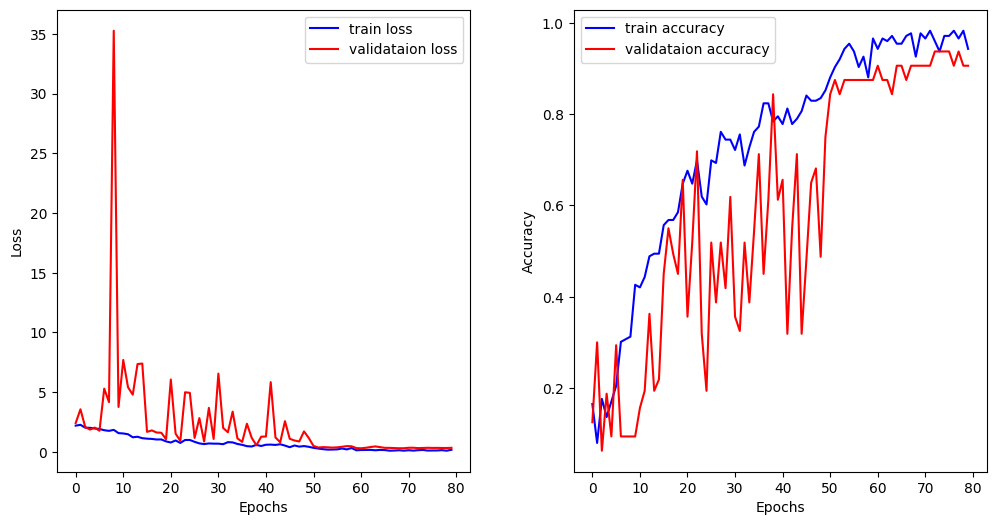

In [ ]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

In [ ]:
torch.save(model.state_dict(), "jaffe_resnet18_not_pretrained.pth")

# Define GradCAM function

In [ ]:
def grad_cam(model, image, target_class, target_layer):
    """
    Perform Grad-CAM manually.

    Args:
        model (torch.nn.Module): Trained model.
        image (torch.Tensor): Input image of shape (1, C, H, W).
        target_class (int): Class index for which Grad-CAM is computed.
        target_layer (torch.nn.Module): Target convolutional layer.

    Returns:
        heatmap (np.array): Grad-CAM heatmap.
    """
    # Forward pass
    model.eval()
    features = []
    gradients = []

    # Hook to capture activations and gradients
    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image)
    pred = F.softmax(output, dim=1)

    # Backward pass for the target class
    model.zero_grad()
    pred[0, target_class].backward()

    # Get captured activations and gradients
    activations = features[0].detach()  # Feature maps from forward pass
    gradients = gradients[0].detach()  # Gradients from backward pass

    # Global average pooling of gradients
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

    # Weighted sum of feature maps
    cam = torch.sum(weights * activations, dim=1).squeeze()

    # ReLU activation (remove negative values)
    cam = F.relu(cam)

    # Normalize heatmap
    cam -= cam.min()
    cam /= cam.max()

    # Detach hooks
    handle_forward.remove()
    handle_backward.remove()

    return cam.cpu().numpy()

# Define GradCAM heatmap overlay function

In [ ]:
def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay Grad-CAM heatmap on the original image.

    Args:
        image (np.array): Original image in RGB format.
        heatmap (np.array): Grad-CAM heatmap.
        alpha (float): Transparency factor for overlay.
        colormap (int): OpenCV colormap for heatmap.

    Returns:
        overlay (np.array): Image with Grad-CAM overlay.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to match image size

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Generate GradCAM for correct predictions

In [ ]:
# Load the trained model weights
model.load_state_dict(torch.load("jaffe_resnet18_not_pretrained.pth"))

<ipython-input-71-e03d5d4ae38d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("jaffe_resnet18_not_pretrained.pth"))


<All keys matched successfully>

In [ ]:
target_layer = model.layer4[1].conv2  # Choose the last convolutional layer
#target_layer = model.layer4[2].conv3

# Find correctly predicted test samples

In [ ]:
def find_correct_test_samples(model, dataloader):
    model.eval()

    correct_samples = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            # collect the correctly predicted test samples
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_samples.append((images, labels))

    return correct_samples

correct_samples = find_correct_test_samples(model, test_dataloader)
print(len(correct_samples))

Testing...:   0%|          | 0/24 [00:00<?, ?it/s]

23


# Apply Grad-CAM to correctly predicted test samples

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


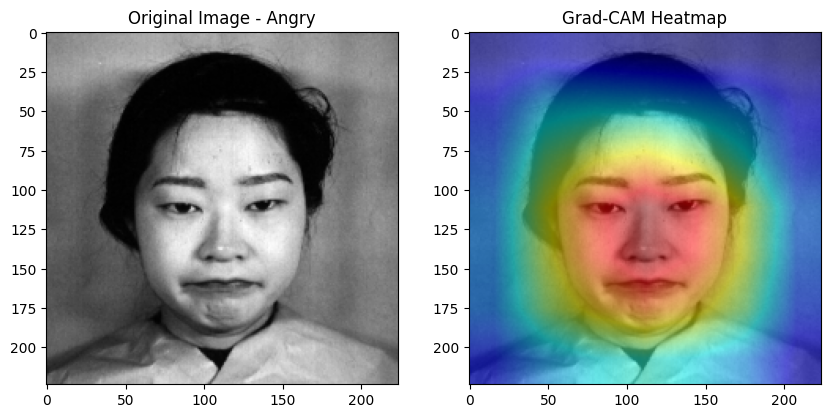

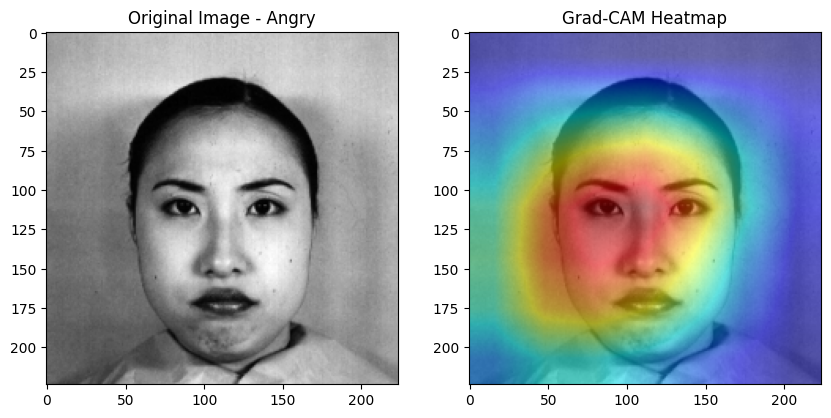

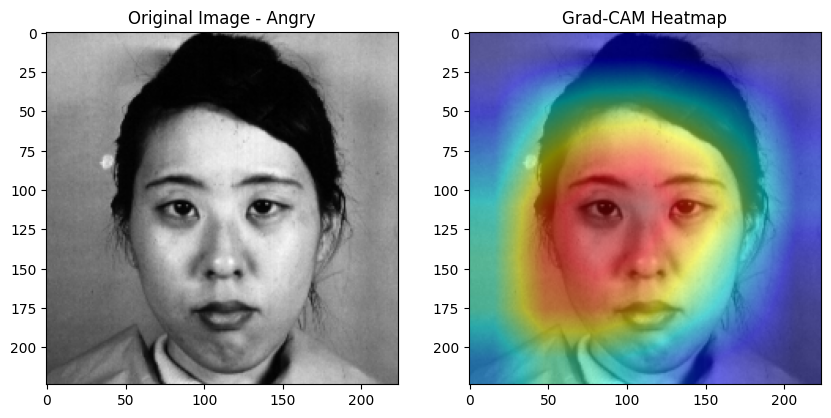

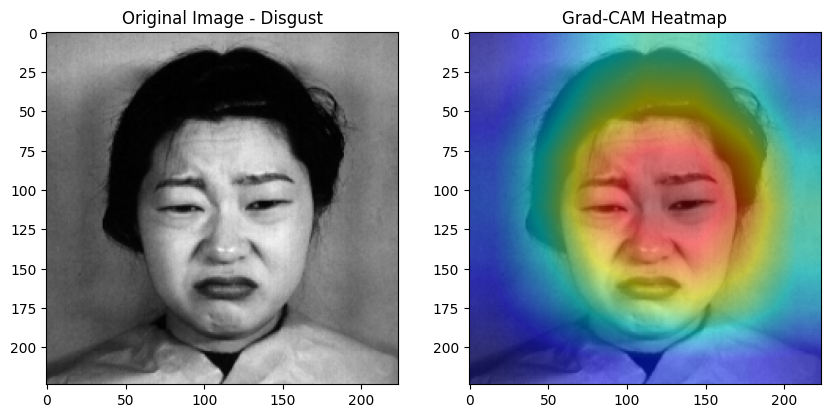

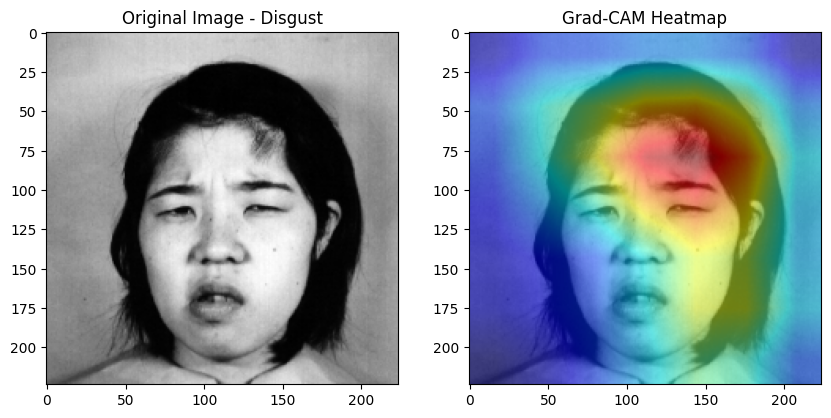

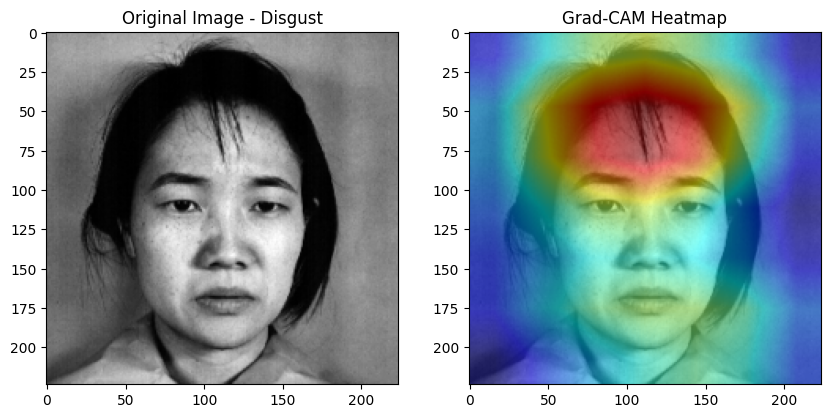

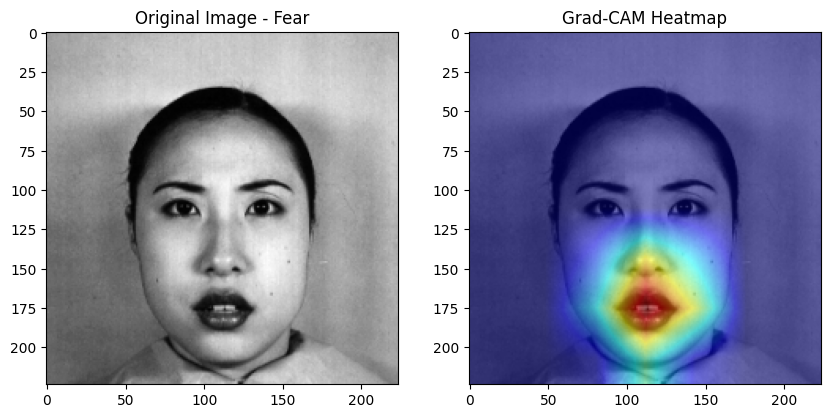

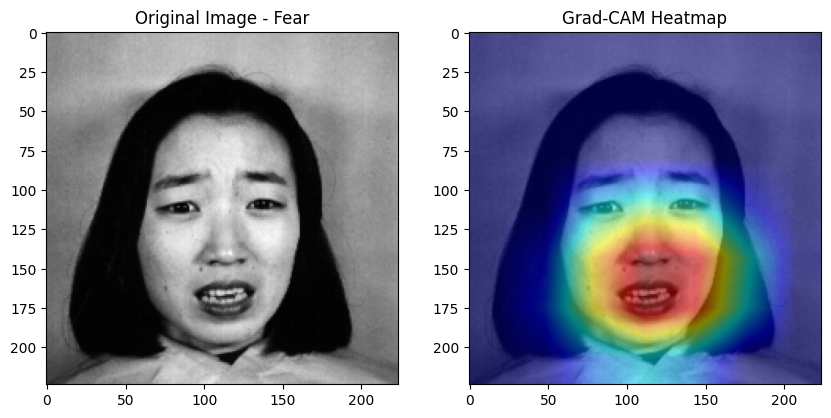

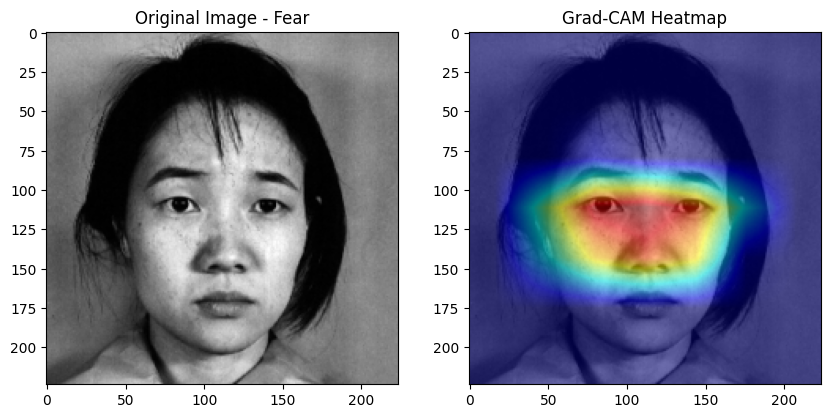

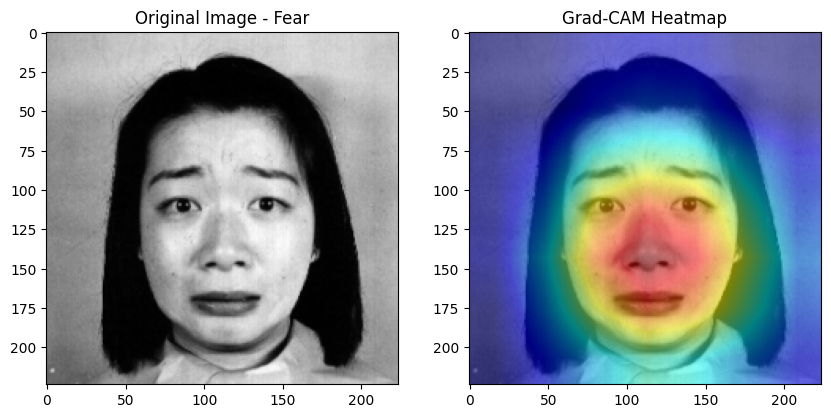

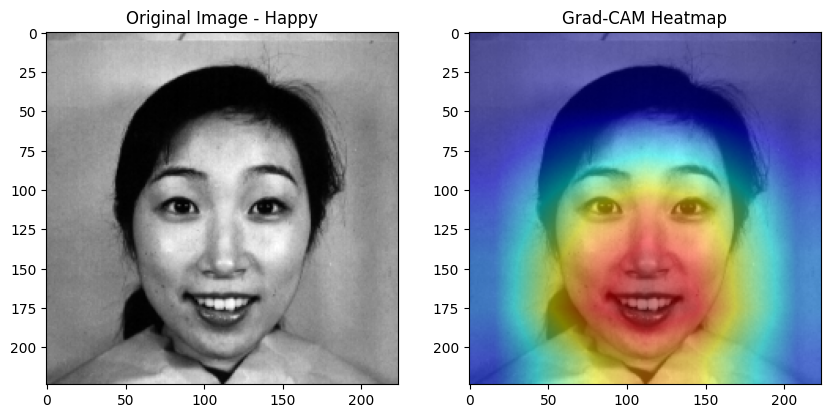

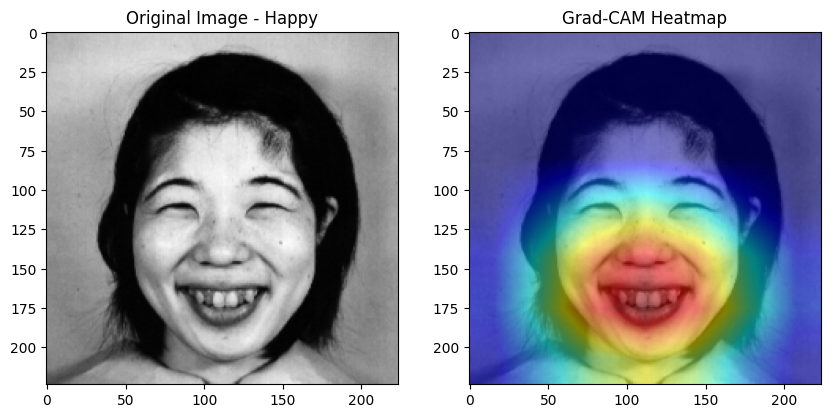

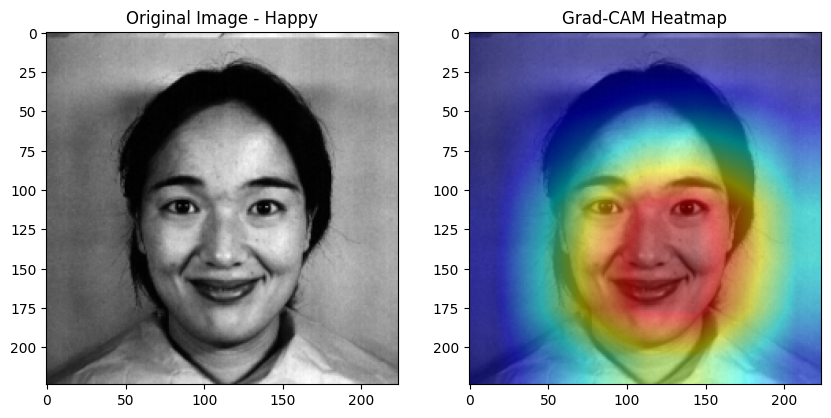

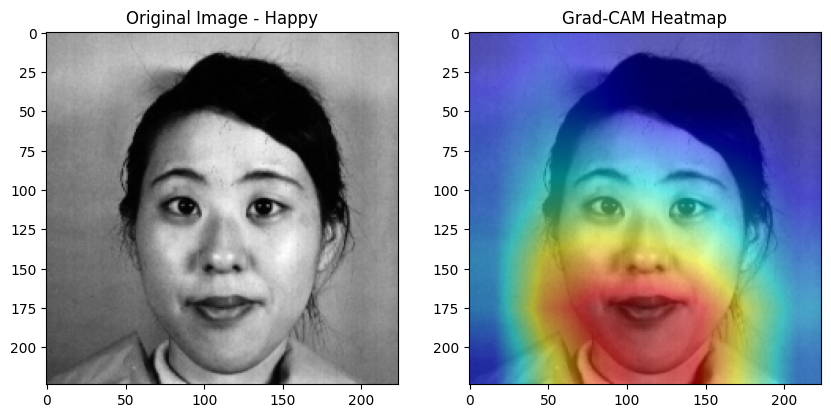

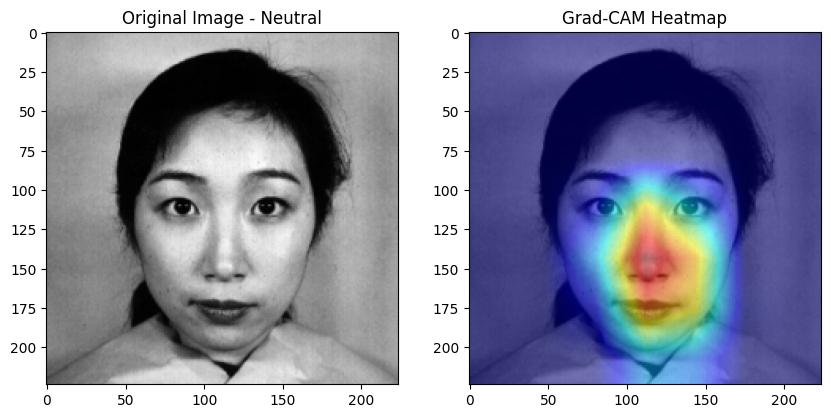

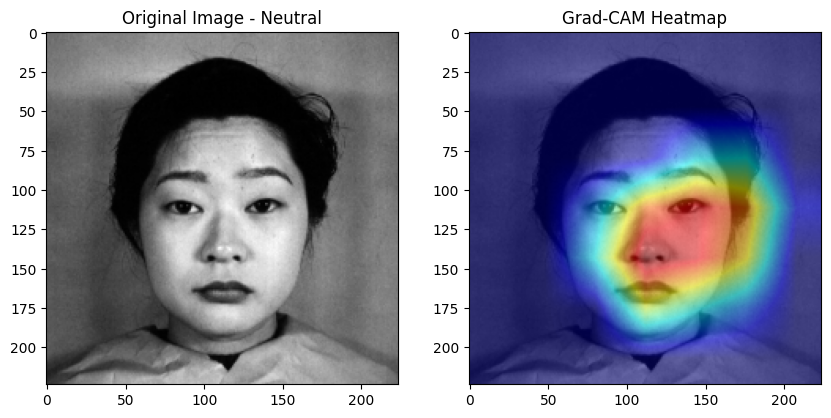

<ipython-input-70-99ecc5733d53>:16: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)


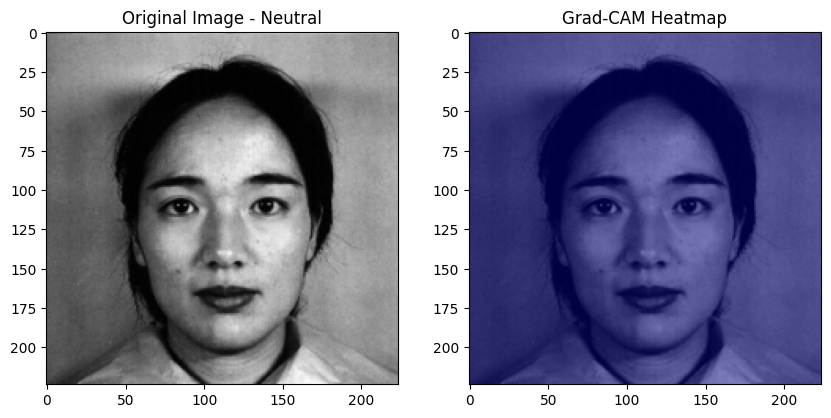

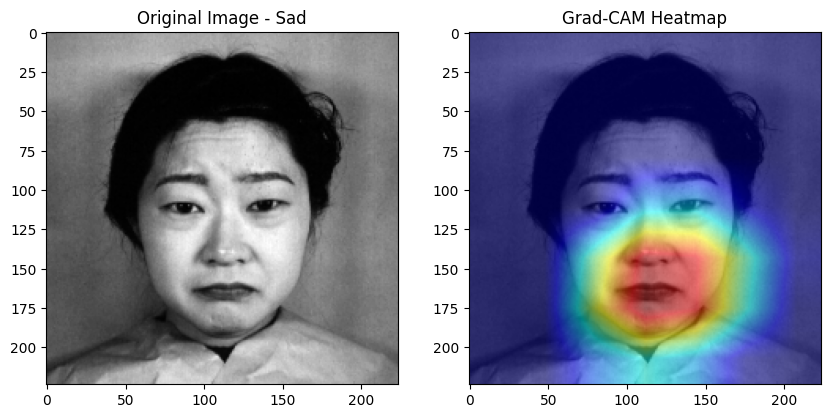

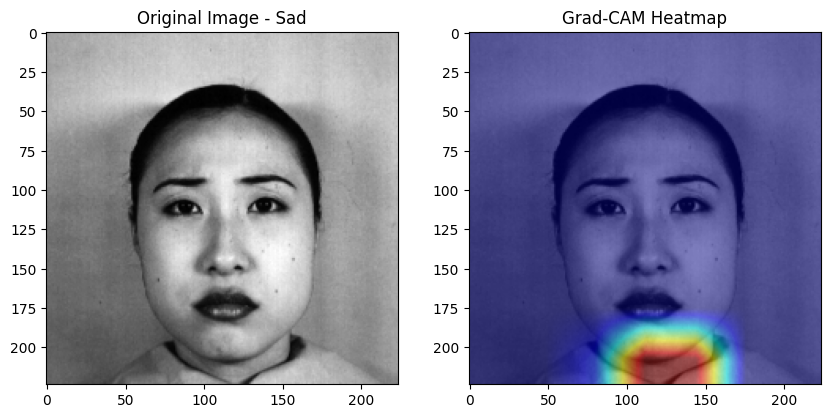

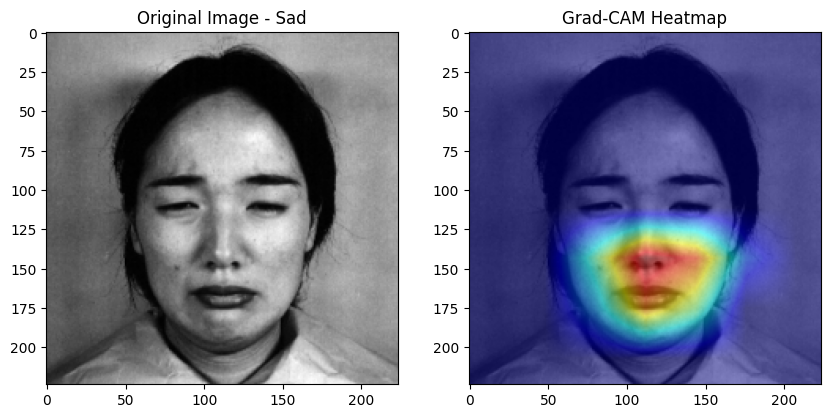

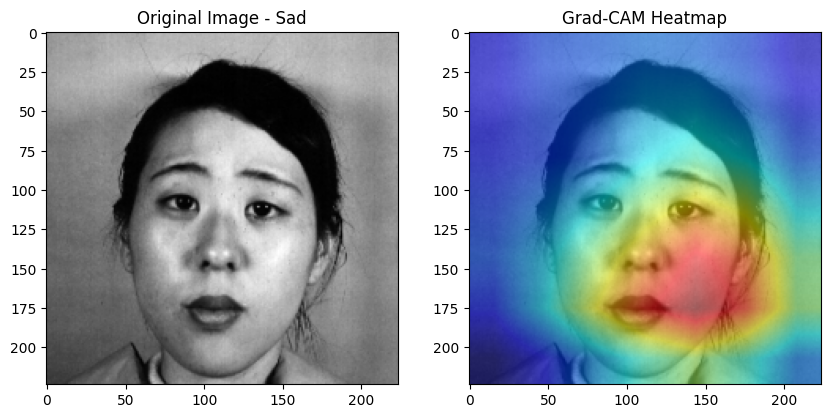

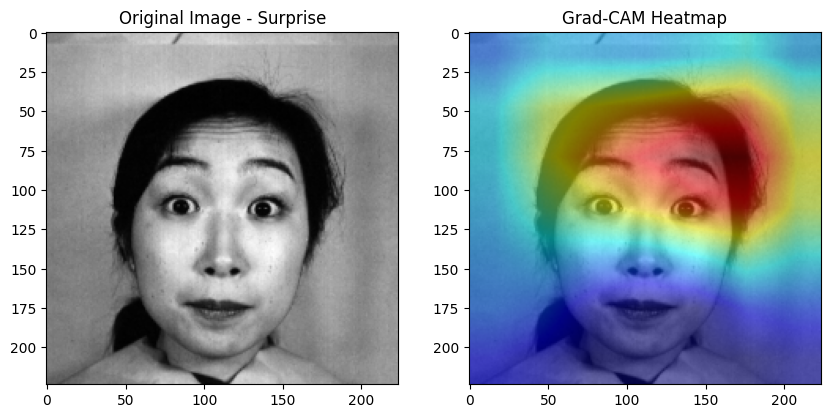

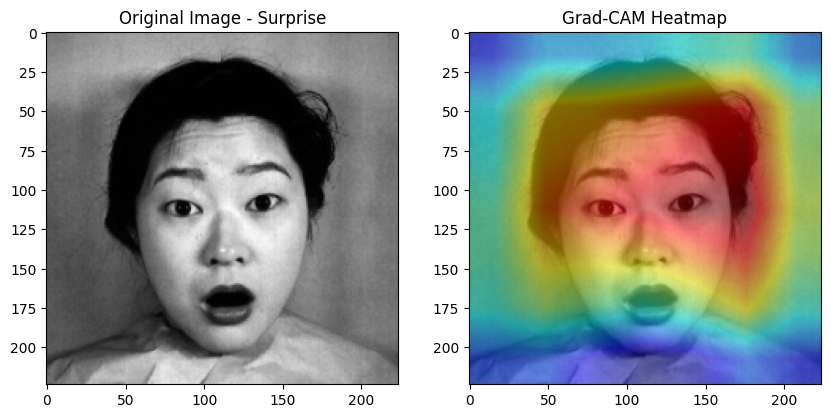

In [ ]:
# Apply Grad-CAM to correctly predicted test samples
for idx, (image, label) in enumerate(correct_samples):
    cam = grad_cam(model, image, label, target_layer)

    # Prepare the image for visualization
    input_image = image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalize to [0, 1]
    input_image = np.uint8(255 * input_image)

    # Overlay the Grad-CAM heatmap
    overlay = overlay_heatmap(input_image, cam)

    emotions = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise"}
    label = emotions[label[0]]

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Original Image - {}".format(label))

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.show()